In [113]:
import pandas as pd
from typing import Dict, Callable, List
import ray
ray.init(num_cpus=4)

2024-04-03 17:19:27,274	INFO worker.py:1642 -- Started a local Ray instance.


Python version:,3.7.4
Ray version:,2.7.2


In [139]:
# Defined based on the logic you are doing
def grouped_mean_chunk(df: pd.DataFrame, groupCols: List, selectCol: str, **kwargs) -> pd.DataFrame:
    return df.groupby(groupCols)[selectCol].agg(['count', 'sum'])

# Defined based on the logic you are doing
def grouped_mean_agg(df: pd.DataFrame, rename: str, groupCols: List, **kwargs) -> pd.DataFrame:
    df = df.reset_index()
    agg_df = df.groupby(groupCols).agg(total_sum=('sum', 'sum'), total_count=('count', 'sum'))
    agg_df[rename] = agg_df.apply(lambda row: row['total_sum'] / row['total_count'], axis=1)
    
    return agg_df[rename].reset_index()

# Will not be changed
@ray.remote
def process_chunk(chunk: pd.DataFrame, dfMethod: Callable, **kwargs) -> pd.DataFrame:
    """
    Calculate the mean of specified columns, grouped by a specified category, for a given DataFrame chunk.

    Args:
    - chunk (pd.DataFrame): A chunk of the DataFrame.
    - dfMethod (Callable): A function that takes in a dataframe as an input and returns a dataframe
    - **kwargs: Additional keyword arguments to pass to dfMethod.

    Returns:
    - pd.DataFrame
    """
    return dfMethod(chunk, **kwargs)

# Will not be changed
def process_file(file_path: str, dfMethod: Callable, aggMethod: Callable, separator: str = '\t', save: bool = False, **kwargs) -> None:
    """
    Process a large CSV file to compute grouped means for specified columns and save the results.

    Args:
    - file_path (str): The path to the CSV file.
    - dfMethod (Callable): A function that takes in a dataframe (chunk) as an input and returns a dataframe
    - aggMethod (Callable): A function that aggregates the concatenated results from all chunks
    - separator (str): delimiter for the input file
    - **kwargs: Additional keyword arguments to pass to both dfMethod and aggMethod.
    """
    chunk_size = 1000  # Define chunk size based on system's memory.

    results = []
    for chunk in pd.read_csv(file_path, chunksize=chunk_size, sep=separator, low_memory=False):
        result = process_chunk.remote(chunk, dfMethod, **kwargs)
        results.append(result)

    # Retrieve and combine results from all chunks.
    combined_results = pd.concat(ray.get(results))

    # Uncomment for debugging purposes. 
    # combined_results.to_csv("data/grouped_means_combined.csv", index=True)

    # Final aggregation to ensure accurate mean calculation across all chunks.
    final_result = aggMethod(combined_results, **kwargs)

    if save:
        final_result.to_csv("data/grouped_means_results.csv", index=False)
        
    return final_result

def grams_chunk(df_first: pd.DataFrame, **kwargs) -> pd.DataFrame:
    df = df_first.copy()
    for i in range(len(df)):
    #print(i)
        try:
            df['quantity'][i] = df['quantity'][i].split(" ")
        except:
            continue
    #if df['quantity'][i] == df['quantity'][i]:
       # df['quantity'][i] = df['quantity'][i].split(" ")
    #else:
    #    continue
    #print(len(df['quantity'][i]))
        if len(df['quantity'][i]) == 2:
            if (df['quantity'][i][1] == "g" or df['quantity'][i][1] == "kg"):
                if (df['quantity'][i][1] == "kg"):
                #new_df['quantity'][i][1] = "g"
                    try:
                        df['quantity'][i] = np.float(new_df['quantity'][i][0]) * 1000
                    except:
                        df['quantity'][i] = np.nan
                else:
                    try:
                        df['quantity'][i] = np.float(new_df['quantity'][i][0])
                    except:
                        df['quantity'][i] = np.nan
            else:
                df['quantity'][i] = np.nan
        else:
            df['quantity'][i] = np.nan
    
    return df

# Defined based on the logic you are doing
def grams_agg(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
       
    return df

# Defined based on the logic you are doing
def countries_chunk(df: pd.DataFrame, selectCol: str, **kwargs) -> pd.DataFrame:
    df['countries_en_c'] = df.countries_en.str.lower()

# Strip whitespaces
    df.countries_en_c = df.countries_en_c.str.strip()
    
# Replace multiple whitespaces with only one space
    df.countries_en_c = df.countries_en_c.str.replace(r"\s+", " ")

# Remove whitespaces after comma
    df.countries_en_c = df.countries_en_c.str.replace(r",\s+", ",")

# Remove some special characters (used in regex)
    df.countries_en_c = df.countries_en_c.str.replace(r"[\*|\?|\.]", "")

    df_packagings = df.countries_en_c.str.extractall(r"(?P<countries_1>[^,]+)")

# Reset the index
    df_packagings.reset_index(inplace=True)

# Drop the automatically created column: match
    df_packagings.drop('match', axis=1, inplace=True)

# Remove duplicates
    df_packagings.drop_duplicates(inplace=True)

# Set the code as the index
#df_packagings.set_index('code', inplace=True)

    df_packagings.countries_1.unique()

    df_packagings = df_packagings.merge(df, right_index=True, left_index=True)


# Drop rows where column 'A' has NA values
    df_packagings_dropped = df_packagings.dropna(subset=[selectCol])

    return df_packagings_dropped

# Defined based on the logic you are doing
def countries_agg(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
    
    return df

In [116]:
df = pd.read_csv('small.csv', delimiter='\t')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.



In [123]:
#groupCols = ['food_groups_en']
#selectCol = 'ecoscore_score'
#rename = 'mean_ecoscore_score'

df = process_file(
    file_path='small.csv',
    dfMethod=grams_chunk,
    aggMethod=grams_agg,
    save=False
)

(process_chunk pid=9145) /opt/anaconda3/lib/python3.7/site-packages/ray/_private/workers/default_worker.py:67: SettingWithCopyWarning: 
(process_chunk pid=9145) A value is trying to be set on a copy of a slice from a DataFrame
(process_chunk pid=9145) 
(process_chunk pid=9145) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(process_chunk pid=9145)   parser.add_argument(
(process_chunk pid=9145) /opt/anaconda3/lib/python3.7/site-packages/ray/_private/workers/default_worker.py:80: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(process_chunk pid=9145) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(process_chunk pid=9145) 

In [7]:
# df[ingredient].head()

In [9]:
# df[score_columns].head()

In [10]:
# for key, value in df.isna().mean().items():
#     print(key, value)

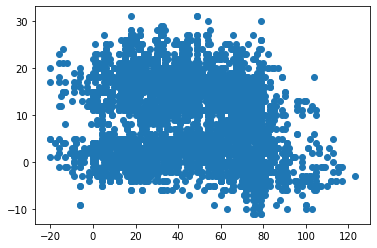

In [80]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(df['ecoscore_score'], df['nutriscore_score'])
plt.show() 

In [83]:
#float(df['quantity'][0][0]) * 2

In [84]:
#f['quantity'][19994] == df['quantity'][19994]

In [81]:
#for i in range(len(df)):
#    if df['quantity'][i] == df['quantity'][i]:
#        df['quantity'][i] = df['quantity'][i].split(" ")
        

In [78]:
#df['quantity']

In [18]:
#new_df = df[~df['quantity'].isna()].reset_index()

In [82]:
#new_df['quantity'].head(900)


for i in range(len(df)):
    #print(i)
    try:
        df['quantity'][i] = df['quantity'][i].split(" ")
    except:
        continue
    #if df['quantity'][i] == df['quantity'][i]:
       # df['quantity'][i] = df['quantity'][i].split(" ")
    #else:
    #    continue
    #print(len(df['quantity'][i]))
    if len(df['quantity'][i]) == 2:
        if (df['quantity'][i][1] == "g" or df['quantity'][i][1] == "kg"):
            if (df['quantity'][i][1] == "kg"):
                #new_df['quantity'][i][1] = "g"
                try:
                    df['quantity'][i] = np.float(new_df['quantity'][i][0]) * 1000
                except:
                    df['quantity'][i] = np.nan
            else:
                try:
                    df['quantity'][i] = np.float(new_df['quantity'][i][0])
                except:
                    df['quantity'][i] = np.nan
        else:
            df['quantity'][i] = np.nan
    else:
        df['quantity'][i] = np.nan
         

In [124]:
quant_df = new_df[~new_df['quantity'].isna()].reset_index()

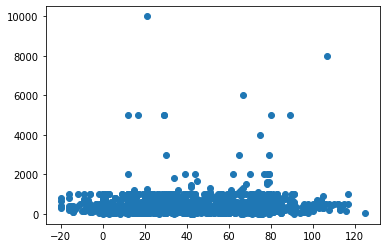

In [125]:
plt.scatter(quant_df['ecoscore_score'], quant_df['quantity'])
plt.show() 

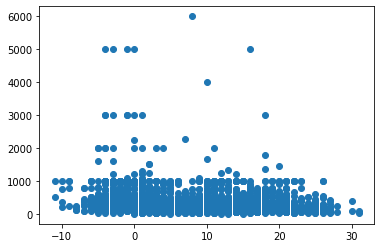

In [126]:
plt.scatter(quant_df['nutriscore_score'], quant_df['quantity'])
plt.show() 

In [127]:
df = quant_df

In [128]:
# Everything in lowercases
df['countries_en_c'] = df.countries_en.str.lower()

# Strip whitespaces
df.countries_en_c = df.countries_en_c.str.strip()

# Replace multiple whitespaces with only one space
df.countries_en_c = df.countries_en_c.str.replace(r"\s+", " ")

# Remove whitespaces after comma
df.countries_en_c = df.countries_en_c.str.replace(r",\s+", ",")

# Remove some special characters (used in regex)
df.countries_en_c = df.countries_en_c.str.replace(r"[\*|\?|\.]", "")

df_packagings = df.countries_en_c.str.extractall(r"(?P<countries_1>[^,]+)")

# Reset the index
df_packagings.reset_index(inplace=True)

# Drop the automatically created column: match
df_packagings.drop('match', axis=1, inplace=True)

# Remove duplicates
df_packagings.drop_duplicates(inplace=True)

# Set the code as the index
#df_packagings.set_index('code', inplace=True)

df_packagings.countries_1.unique()

df_packagings = df_packagings.merge(df, right_index=True, left_index=True)


# Drop rows where column 'A' has NA values
df_packagings_dropped = df_packagings.dropna(subset=['quantity'])




/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
#final_result.to_csv("data/grouped_means_results.csv", index=False)

In [143]:




average_by_country = df.groupby('countries_1')['quantity'].mean().to_frame().reset_index()

average_by_country = average_by_country[average_by_country['countries_1'] != 'en']
average_by_country

TypeError: Could not convert 0.4 kg to numeric

In [141]:
df = process_file(
    file_path='small.csv',
    selectCol='quantity',
    dfMethod=countries_chunk,
    aggMethod=countries_agg,
    save=False
)

(process_chunk pid=9147) /opt/anaconda3/lib/python3.7/site-packages/ray/_private/workers/default_worker.py:108: FutureWarning: The default value of regex will change from True to False in a future version.
(process_chunk pid=9147)   "--runtime-env-agent-port",
(process_chunk pid=9147) /opt/anaconda3/lib/python3.7/site-packages/ray/_private/workers/default_worker.py:111: FutureWarning: The default value of regex will change from True to False in a future version.
(process_chunk pid=9147)   default=None,
(process_chunk pid=9147) /opt/anaconda3/lib/python3.7/site-packages/ray/_private/workers/default_worker.py:114: FutureWarning: The default value of regex will change from True to False in a future version.
(process_chunk pid=9147)   parser.add_argument(
(process_chunk pid=9144) /opt/anaconda3/lib/python3.7/site-packages/ray/_private/workers/default_worker.py:114: FutureWarning: The default value of regex will change from True to False in a future version. [repeated 15x across cluster] (R

In [142]:
df

,level_0,countries_1,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,...,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g,countries_en_c
0,0,france,3596710517510,http://world-en.openfoodfacts.org/product/3596...,kiliweb,1682951305,2023-05-01T14:28:25Z,1709956237,2024-03-09T03:50:37Z,org-auchan-apaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"france,world"
1,0,world,3596710517527,http://world-en.openfoodfacts.org/product/3596...,kiliweb,1672054652,2022-12-26T11:37:32Z,1708232344,2024-02-18T04:59:04Z,org-auchan-apaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"france,world"
2,1,france,3596710517534,http://world-en.openfoodfacts.org/product/3596...,kiliweb,1682936768,2023-05-01T10:26:08Z,1708148079,2024-02-17T05:34:39Z,org-auchan-apaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"france,world"
3,1,world,3596710517640,http://world-en.openfoodfacts.org/product/3596...,smoothie-app,1686043401,2023-06-06T09:23:21Z,1708103678,2024-02-16T17:14:38Z,org-auchan-apaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"france,world"
4,2,france,3596710517657,http://world-en.openfoodfacts.org/product/3596...,kiliweb,1680188892,2023-03-30T15:08:12Z,1708147290,2024-02-17T05:21:30Z,org-auchan-apaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"france,world"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,636,france,3596854448435,http://world-en.openfoodfacts.org/product/3596...,kiliweb,1533574676,2018-08-06T16:57:56Z,1690903404,2023-08-01T15:23:24Z,org-auchan-apaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,france
995,637,france,3596854514956,http://world-en.openfoodfacts.org/product/3596...,kiliweb,1527154272,2018-05-24T09:31:12Z,1698344997,2023-10-26T18:29:57Z,teolemon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,france
997,639,france,3596854646664,http://world-en.openfoodfacts.org/product/3596...,kiliweb,1507374534,2017-10-07T11:08:54Z,1690903405,2023-08-01T15:23:25Z,org-auchan-apaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,france
998,640,france,3596854647562,http://world-en.openfoodfacts.org/product/3596...,kiliweb,1576699442,2019-12-18T20:04:02Z,1690903405,2023-08-01T15:23:25Z,org-auchan-apaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,france


In [31]:
!pip install pycountry

/opt/anaconda3/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,
     |████████████████████████████████| 10.1MB 104kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-cp37-none-any.whl size=10681832 sha256=a1638e5f561cbed8fabcd09b19ab7cf404c4642d8d30d026d007fcdc270c8338
  Stored in directory: /Users/matthewbonner/Library/Caches/pip/wheels/7a/c3/f8/3e164430062ee08d5b8bc8fcd1b891ce54c7ad99871aa3adc1
Successfully built pycountry


In [130]:

import pycountry
import plotly.express as px

iso_mapping = {}
for country in average_by_country['countries_1']:
    try:
        country_data = pycountry.countries.search_fuzzy(country)[0]
        iso_mapping[country] = country_data.alpha_3
    except LookupError:
        print(f"No ISO code found for {country}. Dropping from DataFrame.")
        average_by_country = average_by_country[average_by_country['countries_1'] != country]

# Add ISO codes to the DataFrame
average_by_country['ISO_Code'] = average_by_country['countries_1'].map(iso_mapping)

# Plot the scores on a geographical map
fig = px.choropleth(average_by_country,
                    locations="ISO_Code",
                    color="quantity",
                    hover_name="countries_1",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Scores by Country")
fig.show()

No ISO code found for fr:schweiz. Dropping from DataFrame.
No ISO code found for royaume-uni. Dropping from DataFrame.
No ISO code found for world. Dropping from DataFrame.


In [131]:
df_cats = df_packagings.dropna(subset=['main_category_en'])


In [132]:
average_by_cat = df_cats.groupby('main_category_en')['quantity'].mean().to_frame().reset_index()


In [133]:
average_by_cat.head()

,main_category_en,quantity
0,Acid gummy candies,105.000000
1,Advent calendars,200.000000
2,Alaska pollock,600.000000
3,Albacore,123.392857
4,Alimentos-y-bebidas-de-origen-vegetal-alimento...,335.000000


In [134]:
import plotly.express as px
fig = px.treemap(average_by_cat, path = ['main_category_en'], values='quantity',
                  color='main_category_en')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [107]:
sort = average_by_cat.sort_values('quantity', ascending = False)

In [108]:
top20 = sort.head(20)

In [109]:
fig = px.treemap(top20, path = ['main_category_en'], values='quantity',
                  color='main_category_en')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [110]:
bottom20 = sort.tail(20)

fig = px.treemap(bottom20, path = ['main_category_en'], values='quantity',
                  color='main_category_en')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [65]:
#df2 = pd.read_csv('small.csv', delimiter='\t')

In [69]:
#df2[df2['main_category_en'] == "Tuna fillets"]['quantity']

In [64]:
#df2['quantity'].tail(50)